# First Analysis of the Experiment Data

In [1]:
import numpy as np
import pandas as pd
import collections, os, sys, random, time, pickle, dill, copy, re
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa
from project_code.experiments2 import Experiment
from project_code.semspace import SemSpace

bhsa_data_paths=['~/github/etcbc/bhsa/tf/c',
                 '~/github/verb_semantics/project_code/lingo/heads/tf/c',
                 '~/github/verb_semantics/project_code/sdbh']

TF = Fabric(bhsa_data_paths)
tf_api = TF.load('''
                function lex lex_utf8 vs language
                pdp freq_lex gloss domain ls
                mother rela typ sp st code txt instruction
                heads prep_obj 
                prs prs_gn prs_nu prs_ps
                sem_domain sem_domain_code
              ''', silent=True)

tf_api.makeAvailableIn(globals())
B = Bhsa(api=tf_api, name='', version='c')

This is Text-Fabric 5.3.3
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

118 features found and 0 ignored


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="{provenance of this corpus}">BHSA</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="{CORPUS.upper()} feature documentation">Feature docs</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/Bhsa/" title="BHSA API documentation">BHSA API</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/" title="text-fabric-api">Text-Fabric API 5.3.3</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/#search-templates" title="Search Templates Introduction and Reference">Search Reference</a>

In [2]:
print('Loading cached experiments...')
with open('/Users/cody/Documents/experiments.dill', 'rb') as infile:
    experiments = dill.load(infile)
    print(f'{len(experiments)} experiments loaded.')

Loading cached experiments...
50 experiments loaded.


In [3]:
print('Loading semantic space data: adjusting counts with pmi, preparing plotter functions, etc...')

spaces = dict((exp_name, SemSpace(exp, info=False)) for exp_name, exp in experiments.items())

print(f'{len(spaces)} experiments successfully loaded into semantic spaces.')

Loading semantic space data: adjusting counts with pmi, preparing plotter functions, etc...
50 experiments successfully loaded into semantic spaces.


## Experiments and their Shapes

In [4]:
for shape, exp in sorted((experiments[exp].data.shape, exp) for exp in experiments):
    print(f'{exp}:\t{shape}')

vi_subj_animacy:	(2, 180)
vi_allarg_pa:	(2, 694)
vi_objc_pa:	(2, 714)
vi_adj+_pa:	(2, 734)
vi_cmpl_pa:	(2, 734)
vi_coad_pa:	(2, 734)
vf_obj_pa:	(3, 694)
vd_domain_simple:	(3, 704)
vf_cmpl_pa:	(4, 725)
vi_objc_animacy:	(5, 173)
vf_adju_pa:	(7, 733)
vf_obj_animacy:	(8, 127)
vf_coad_pa:	(8, 734)
vg_tense:	(8, 734)
vi_cmpl_animacy:	(39, 174)
vf_argAll_pa:	(43, 703)
vi_adj+_animacy:	(46, 108)
vi_coad_animacy:	(51, 241)
vd_domain_embed:	(73, 646)
vf_cmpl_animacy:	(88, 158)
vi_allarg_animacy:	(92, 370)
vf_adju_animacy:	(96, 78)
vf_coad_animacy:	(200, 192)
vi_subj_domain:	(247, 231)
vd_par_lex:	(305, 365)
vf_argAll_animacy:	(378, 207)
vi_objc_domain:	(448, 245)
vf_obj_domain:	(584, 213)
vi_cmpl_domain:	(1033, 223)
vf_cmpl_domain:	(1128, 207)
vi_adj+_domain:	(1219, 217)
vf_adju_domain:	(1575, 180)
vi_coad_domain:	(1735, 386)
vi_subj_lex:	(1959, 290)
vi_objc_lex:	(2251, 305)
vi_allarg_domain:	(2902, 527)
vf_obj_lex:	(3012, 274)
vf_coad_domain:	(3055, 301)
vi_adj+_lex:	(3478, 295)
vf_cmpl_lex:	(4

#### Count Adjustments 

For experiments that include a lot of lexical data, we employ the pointwise mutual information score to adjust the raw counts. But for experiments with small-scale, categorical variables this does not make sense. The goal with categorical data is not to weigh surprising lexical occurrences, but to measure tendencies. For these it is probably more appropriate to use a ratio.

Animacy experiments contain mixtures of lexical and categorical data. But lexical data is minimal in experiments that do not strongly weigh prepositional phrases such as object experiments. Thus, for these experiments we normalize with a ratio rather than ppmi. By contrast to the vf_obj_animacy experiment, which has 8 unique values, the vf_adju_animacy and vf_cmpl_animacy experiments have 96 and 200 unique values, respectively. These are more suitable for ppmi adjustment.

In [75]:
countType = {}

for exp_name, exp in experiments.items():
    if exp.data.shape[0] < 9:
        print(exp_name)
        print(list(exp.data.index.unique()))
        print()
        countType[exp_name] = 'sim_norm_raw'
    else:
        countType[exp_name] = 'sim_pmi_nogloss'

vi_subj_animacy
['animate', 'inanimate']

vi_objc_pa
['Objc', 'ø']

vi_objc_animacy
['>CR_animate', 'C_animate', 'KJ_animate', 'animate', 'inanimate']

vi_cmpl_pa
['Cmpl', 'ø']

vi_adj+_pa
['adj+', 'ø']

vi_coad_pa
['coad', 'ø']

vi_allarg_pa
['arg', 'ø']

vd_domain_simple
['D', 'N', 'Q']

vg_tense
['impf', 'impv', 'infa', 'infc', 'perf', 'ptca', 'ptcp', 'wayq']

vf_obj_pa
['Objc', 'Objc|Objc', 'ø']

vf_obj_animacy
['>CR_animate', 'C_animate', 'KJ_animate', 'animate', 'animate|animate', 'animate|inanimate', 'inanimate', 'inanimate|inanimate']

vf_cmpl_pa
['Cmpl', 'Cmpl|Cmpl', 'Cmpl|Cmpl|Cmpl', 'ø']

vf_adju_pa
['adj+', 'adj+|adj+', 'adj+|adj+|adj+', 'adj+|adj+|adj+|adj+', 'adj+|adj+|adj+|adj+|adj+', 'adj+|adj+|adj+|adj+|adj+|adj+|adj+', 'ø']

vf_coad_pa
['coad', 'coad|coad', 'coad|coad|coad', 'coad|coad|coad|coad', 'coad|coad|coad|coad|coad', 'coad|coad|coad|coad|coad|coad', 'coad|coad|coad|coad|coad|coad|coad', 'ø']



## Deriving a Verb Specimen Set

Which verbs will comprise this study? This depends on which verbs are accounted for in the dataset. The presence/absence (pa) experiments count the most basic features, namely, the simple presence or absence of a given verbal argument: objects, complements, adjuncts. I will first try to derive a specimen set by taking the intersection of all the pa experiments.

In [76]:
specimens = set(experiments['vi_objc_pa'].data.columns)
freq_count = collections.Counter()
print(f'Starting with specimens count of {len(specimens)}')

for exp_name, experiment in experiments.items():
    
    if not 'vi_objc_pa' or not re.match('.*_pa', exp_name): # skip first pa experiments or non-pa exps.
        continue
        
    exp_lexemes = set(experiment.data.columns)
    specimens = exp_lexemes & specimens
    
    # make frequency count of lexemes
    for lex in experiment.data.columns:
        if lex in specimens:
            freq_count[lex] += experiment.data[lex].sum()
    
print(f'Complete with specimen count of {len(specimens)}')

Starting with specimens count of 714
Complete with specimen count of 292


### Count Lexemes without Stems

All verbs have their stem appended. How many plain lexemes are in the specimen set?

In [77]:
plain_lexs = set(lex.split('.')[0] for lex in specimens)
lex_nodes = [(next(l for l in F.otype.s('lex') if F.lex.v(l) == lex),) for lex in plain_lexs]

print(f'Number of plain lexemes accounted for: {len(plain_lexs)}\n')
B.show(lex_nodes)

Number of plain lexemes accounted for: 238



We have a good and diverse dataset here. Let's see what the makeup of stems are.

### Stem Counts

In [78]:
stem_counts = collections.Counter(lex.split('.')[1] for lex in specimens)

stem_counts.most_common()

[('qal', 165),
 ('hif', 57),
 ('piel', 40),
 ('nif', 24),
 ('hit', 4),
 ('hof', 1),
 ('hsht', 1)]

## Coverage of Specimens throughout the Experiments

There are 297 verb specimens present with 243 plain lexical forms. Note that many of the experiments have different numbers of specimens present, due to the various requirements per experiment. We intend to use as much data as is present to inform the verb clustering. But are there some verbs whose coverage throughout all 50 experiments is especially lacking?

Below we count per lexeme how many different experiments it occurs in. The number itself is then counted.

In [79]:
spread_count = collections.Counter()
accounted_exps = set()

for lex in specimens:
    count = 0
    for exp_name, exp in experiments.items():
        if lex in exp.data.columns:
            count += 1
            accounted_exps.add(exp_name)
    spread_count[count] += 1
    
spread_count.most_common()

[(50, 26),
 (48, 14),
 (17, 14),
 (25, 13),
 (44, 13),
 (41, 12),
 (21, 11),
 (19, 11),
 (40, 11),
 (42, 10),
 (18, 10),
 (49, 10),
 (32, 10),
 (29, 9),
 (23, 8),
 (39, 8),
 (37, 8),
 (34, 8),
 (33, 7),
 (46, 7),
 (22, 7),
 (36, 7),
 (31, 6),
 (24, 6),
 (30, 6),
 (27, 5),
 (47, 5),
 (43, 5),
 (26, 5),
 (20, 4),
 (45, 4),
 (38, 4),
 (35, 3),
 (16, 2),
 (28, 2),
 (15, 1)]

What is the lowest accounted-for lexemes and how many of them are there?

In [80]:
min(spread_count.most_common())

(15, 1)

In [81]:
sum([amount for count, amount in spread_count.most_common() if count<20])

38

In [82]:
38/297 # ratio of total specimens within 20 or less experiments

0.12794612794612795

Only 1 lexeme is accounted for in only 15 of the experiments. 38 of the 297 verb specimens (12%) have less than 20 applicable experiments. These are acceptable amounts. Verbs that do not have an attested object, for instance, will not appear in 3 of 4 object experiments. But they *will* occur in the presence/absence object experiment. So it can be expected that certain verbs will be less accounted-for in various experiments.

## Examining Distributions of Presence/Absence Inventory Experiments

Presence/absence experiments test whether and how often a given verb occurs with a given argument. Each experiment tests a single argument or combined set of arguments. These are: objects, complements, adjuncts, complements + adjuncts, and all arguments. For each argument type, there is a simple binary variable: present or not. Below we normalize across verbs to observe the distribution of verbs with the given argument.

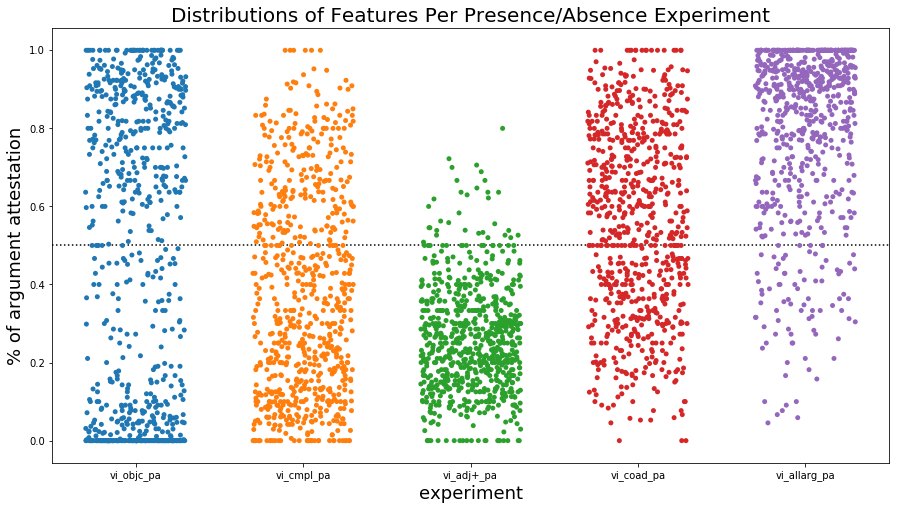

In [83]:
vi_datas = pd.DataFrame((experiments['vi_objc_pa'].data / experiments['vi_objc_pa'].data.sum()).loc['Objc']) # normalized objc data
vi_datas.columns = ('ratio of attestation',)
vi_datas['experiment'] = 'vi_objc_pa'

for exp_name, experiment in experiments.items():
    
    if exp_name == 'vi_objc_pa' or not re.match('vi_.*_pa', exp_name): # skip any non-pa experiments
        continue
        
    exp = experiment.data / experiment.data.sum() # normalize

    arg = next(i for i in exp.index if i != 'ø')
    
    datas = pd.DataFrame(exp.loc[arg])
    datas.columns = ('ratio of attestation',)
    datas['experiment'] = exp_name
    
    vi_datas = pd.concat((vi_datas, datas))

plt.figure(figsize=(15,8))
plt.title('Distributions of Features Per Presence/Absence Experiment', fontsize=20)
sns.stripplot(x='experiment', y='ratio of attestation', data=vi_datas, jitter=0.3)
plt.xlabel('experiment', fontsize=18)
plt.ylabel('% of argument attestation', fontsize=18)
plt.axhline(0.5, color='black', linestyle='dotted')

Points on the graph are individual verbs, for each of which we look at the percentage of its overall uses with the argument in question (e.g. the blue points show how often verbs occur with an object).

### Initial Observations

The combined, complement + adjunct experiment seems to have the most even distribution of features. The object presence/absence experiment appears to show the most separation between verbs. The adjunct tends to have <50% attestation, while the opposite is true for the allarg experiment.

It is possible to venture a few generalizations based on this visual:

* Verbs appear to exhibit a more even polarity between the presence/absence of an object argument.
* The number of verbs that occur with or without a complementizer appear to be fairly balanced, with a slight preference for <50% of those verbs' occurrences having a complement.
* There are more verbs with ≤50% of adjunct elements.
* The number of verbs with a higher proportion of complement or adjunct arguments is seems evenly distributed, with a slight preference for >50%.
* The number of verbs with a proportion >50% of any of the arguments appears to be high. 

#### Number of Verbs with 100% or 0% Objc

In [84]:
ratioedO = experiments['vi_objc_pa'].data / experiments['vi_objc_pa'].data.sum()
allO = ratioedO.loc['Objc'][ratioedO.loc['Objc'] == 1.0]
noO = ratioedO.loc['Objc'][ratioedO.loc['ø'] == 1.0]

print(f'{allO.shape[0]} verbs that have an object 100% of the time...')
print(f'{noO.shape[0]} verbs that never occur with an object...')

39 verbs that have an object 100% of the time...
148 verbs that never occur with an object...


#####  Verbs with 100% Objects

In [85]:
#print(' | '.join(allO.index))

##### Verbs with 0% Objects

In [86]:
#print(' | '.join(noO.index))

In [87]:
# B.show(B.search('''

# clause
#     phrase function=Pred
#         word lex=BW>[ vs=qal

#     phrase function=Objc
# '''))

BW> with objects is a good example of the shortcomings of the ETCBC "object" label, which does not sharply distinguish between "objects" and "complements." Note however the group of verbs just beneath the 20% marker in the strip chart. Are many of these motion verbs like BW>?

In [88]:
smallO = ratioedO.loc['Objc'][ratioedO.loc['Objc'] <= 0.20]
print(f'{smallO.shape[0]} verbs that have an object ≤20% of the time...')

289 verbs that have an object ≤20% of the time...


In [89]:
#print(' | '.join(smallO.index))

## Similarity Analysis

For each specimen, calculate its similarity with all other specimens pairwise based on all experiments which they have in common. The similarity scores will be averaged across all of the shared experiments. All raw counts have been adjusted using the pointwise mutual information (pmi) score. 

### Averaged Similarity Scores

Average similarities across all experiments to derive a list of test cases.

In [90]:
sim_matrix = pd.DataFrame(np.zeros(shape=(len(specimens), len(specimens))), columns=specimens, index=specimens) # for pairwise similarities
common_matrix = pd.DataFrame(np.zeros(shape=(len(specimens), len(specimens))), columns=specimens, index=specimens) # for counting number of common experiments

for lex in specimens:
    for space_name, space in spaces.items():
        
        sim_measure = eval(f'space.{countType[space_name]}')
        
        if lex not in sim_measure.columns:
            continue
        
        sim_matrix[lex] = sim_matrix[lex].add(sim_measure[lex], fill_value=0)
        common_matrix[lex] += 1
        
sim = sim_matrix / common_matrix

In [91]:
#list(sim.columns)

In [92]:
sim['PYH[.qal']['PTX[.qal']

0.5789419727828938

In [93]:
sim['HJH[.qal'].sort_values(ascending=False).head(10)

HJH[.qal    1.000000
<FH[.qal    0.403659
NTN[.qal    0.392149
QR>[.qal    0.368986
BW>[.qal    0.366295
JY>[.qal    0.361479
<BR[.qal    0.352909
HLK[.qal    0.351303
R>H[.qal    0.349556
<LH[.qal    0.338293
Name: HJH[.qal, dtype: float64

### Looking at Surprise Word Similarities

One of the major goals of this project is to determine how verb meanings and classes are naturally distinguished by their context. היה is an interesting case of a verb which likely has no exact synonyms, but which exhibits similarity across all averaged experiments with words that are seemingly unsimilar such as נתן, עשה, בוא, etc. (see above). The purpose of gathering various kinds of contexts via the experiment parameters is to discover which contexts in particular are similar or different in various kinds of verbs. In this case, I want to know how the similarities of נתן and היה compare with words that are intuitively more similar to נתן such as שׂים and לקח, both of which are included in the top 10 similar terms to נתן along with היה (see below). For this, I will create a visualization that will allow me to visually compare the patterns of similarity between two given words amongst the various experiments. This will be a barchart with all similarity ratings from all the various parameters. The bars should be color-coded and logically grouped so that relevant patterns can be easily identified. This will hopefully allow me to observe where the key differences are between words with intuitive similarity and words without. It might also help determine why certain words are unintuitively rated as more similar than others.

In [94]:
sim['NTN[.qal'].sort_values(ascending=False).head(10)

NTN[.qal    1.000000
FJM[.qal    0.465611
<FH[.qal    0.440594
BW>[.hif    0.433826
LQX[.qal    0.414023
HJH[.qal    0.392149
NF>[.qal    0.390903
QR>[.qal    0.380792
CWB[.hif    0.374986
JY>[.hif    0.362763
Name: NTN[.qal, dtype: float64

### Deriving A Plot Arrangement

The arrangment of experiment parameters on the plot is important, since I hope to use it to identify patterns. So here I develop an ordering and color scheme to be used with all of the plots.

##### Concept: Develop an ordering scheme based on specificity of parameters
I can attempt to arrange elements from more to less specific parameters. An example of a "specific" parameter would be one with lexical arguments, while a "general" parameter might only count the presence or absence of a given argument. Below is a concept of priorities:

1. verb grammar (vg)
    1. verb tense
2. verb domain (vd)
    1. simple domain
    2. embedded domain
    3. context clause chain
    4. context clause
    5. parallelism
    6. context window
3. verb inventories (allargs, adjunct, complement, object)
    1. presence
    2. animacy
    3. domain
    4. lexemes
4. verb frames
    1. same order as verb inventories

In [95]:
# make bar orders

verb_grammar = ['vg_tense']

verb_domain = '''
vd_domain_simple
vd_domain_embed
vd_con_chain
vd_con_clause
vd_par_lex
vd_con_window
'''.strip().split('\n')

verb_inventories = '''
vi_allarg_pa
vi_coad_pa
vi_adj+_pa
vi_cmpl_pa
vi_objc_pa
vi_subj_animacy
vi_allarg_animacy
vi_coad_animacy
vi_adj+_animacy
vi_cmpl_animacy
vi_objc_animacy
vi_subj_domain
vi_allarg_domain
vi_coad_domain
vi_adj+_domain
vi_cmpl_domain
vi_objc_domain
vi_allarg_lex
vi_coad_lex
vi_subj_lex
vi_adj+_lex
vi_cmpl_lex
vi_objc_lex
'''.strip().split('\n')

verb_frames = '''
vf_argAll_pa
vf_coad_pa
vf_adju_pa
vf_cmpl_pa
vf_obj_pa
vf_argAll_animacy
vf_coad_animacy
vf_adju_animacy
vf_cmpl_animacy
vf_obj_animacy
vf_argAll_domain
vf_coad_domain
vf_adju_domain
vf_cmpl_domain
vf_obj_domain
vf_argAll_lex
vf_coad_lex
vf_adju_lex
vf_cmpl_lex
vf_obj_lex
'''.strip().split('\n')

# map experiment groups to colors
color2experiment = (('gold', verb_grammar),
                    ('purple', verb_domain),
                    (sns.color_palette(palette='Blues')[4], verb_inventories), 
                    (sns.color_palette(palette='Reds')[3], verb_frames))

# make ordered tuple of colors
expcolors = tuple((exp, color) for color, exp_list in color2experiment # make tuple of colors
                        for exp in exp_list) 

In [137]:
{'man', 'woman'} & {'person', 'man', 'woman'} != {'man', 'woman'}

False

In [197]:
def get_sim_experiments(lex1, lex2, expcolors=expcolors, show=True, returnData=True, wordSet=None):
    '''
    Exports a barchart that illustrates the level
    of similarity between two lexemes per all experiments
    in the dataset.
    '''
    
    sims = dict() # temporarily hold similarity scores here
    
    # gather rated similarities between the two terms for every provided experiment
    for sp_name, space in spaces.items():
        
        sim_measure = eval(f'space.{countType[sp_name]}')
        wordSet = wordSet or {lex1, lex2}

        if wordSet & set(sim_measure.columns) != wordSet: # ensure both terms are in the space
            continue
            
        sims[sp_name] = sim_measure[lex1][lex2] # get similarity
        
    sims_ordered = collections.OrderedDict((exp[0], sims[exp[0]]) for exp in expcolors if exp[0] in sims) # customized order
    sims = pd.DataFrame(list(sims_ordered.items())) # drop into Dataframe
    sims.columns = ['experiment', 'score'] # set col names
    
    if show:
        # plot:
        colors = tuple(expcol[1] for expcol in expcolors if expcol[0] in sims['experiment'].values)
        plt.figure(figsize=(18, 8)) 
        sns.barplot(sims['experiment'], sims['score'], palette=colors, orient='v')
        plt.xticks(rotation='vertical', fontsize=12)
        plt.xlabel('experiment', fontsize=18)
        plt.ylabel('similarity score', fontsize=18)
        plt.title(f'Scored Similarities between {lex1} and {lex2}', fontsize=20)
        
    if returnData:
        return sims
    
def compare_simPatterns(dataset1, dataset2, pairs='', colors=expcolors):
    '''
    Compare barchart similarity patterns accross two barcharts.
    The first dataset is the primary dataset and will be colored
    normally. The second dataset will be colored grey for comparison.
    '''
    
    data1Sims = list(reversed(dataset1['score']))
    data2Sims = list(reversed(dataset2['score']))
    xLocations = np.arange(dataset1.shape[0])
    barwidth = 0.8       # the width of the bars: can also be len(x) sequence
    plt.figure(figsize=(10, 15)) 
    p1 = plt.barh(xLocations, data1Sims, barwidth, color=sns.color_palette(palette='Reds')[3])
    p2 = plt.barh(xLocations, data2Sims, barwidth, color=sns.color_palette(palette='Blues')[4])
    plt.yticks(xLocations, list(reversed(dataset1['experiment'])), fontsize=12)
    
    plt.ylabel('experiment', fontsize=18)
    plt.xlabel('similarity score', fontsize=18)
    plt.title(f'Similarity Differences between {pairs[0]} and {pairs[1]}', fontsize=20)
    
    plt.legend((p1[0], p2[0]), (f'{pairs[0]}', f'{pairs[1]}'), fontsize=12)
    
def compareSets(set1, set2):
    '''
    Compare two pairs of words and their similarity differences.
    '''
    dataset1 = get_sim_experiments(set1[0], set1[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]})
    dataset2 = get_sim_experiments(set2[0], set2[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]})
    
    compare_simPatterns(dataset1, dataset2, pairs=(f'{set1[0]} & {set1[1]}', f'{set2[0]} & {set2[1]}'))
    
def compareChange(set1, set2):
    '''
    Compare two pairs of words and their similarity differences.
    '''
    dataset1 = get_sim_experiments(set1[0], set1[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]})
    dataset2 = get_sim_experiments(set2[0], set2[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]})
    
    change = dataset1
    change['score'] = dataset1['score'] - dataset2['score']
    change['score'] = change['score'] / dataset2['score']
    datachange = list(reversed(change['score']))
    blue = sns.color_palette(palette='Blues')[3]
    red = sns.color_palette(palette='Reds')[4]
    colors = [blue if score > 0 else red for score in datachange]
    
    pairs = f'{set1[0]} & {set1[1]}', f'{set2[0]} & {set2[1]}'
    
    xLocations = np.arange(change.shape[0])
    barwidth = 0.8       # the width of the bars: can also be len(x) sequence
    plt.figure(figsize=(10, 15)) 
    plt.barh(xLocations, datachange, barwidth, color=colors)
    plt.yticks(xLocations, list(reversed(dataset1['experiment'])), fontsize=12)
    plt.ylabel('experiment', fontsize=18)
    plt.xlabel('ratio of similarity score difference', fontsize=18)
    plt.title(f'Similarity Differences between {pairs[0]} and {pairs[1]}', fontsize=20)

<hr>

## Top Verb Similarity Analyses

In this next section we analyze a set of verbs selected from those specimens which occur in all 50 experiments. This set will serve for the case study on multifaceted similarity: explaining and exploring how surprising word similarities arise and how they are distinguishable from similarities that are more intuitive. 

### Deriving a Case Study Set

Further above we have generated a frequency count for each lexeme in the specimen set. This allows us to select the top most common lexemes for the case study.

In [186]:
freq_count.most_common(10)

[('>MR[.qal', 47974.0),
 ('HJH[.qal', 34658.0),
 ('<FH[.qal', 22837.0),
 ('BW>[.qal', 19062.0),
 ('NTN[.qal', 18194.0),
 ('HLK[.qal', 13360.0),
 ('R>H[.qal', 10784.0),
 ('DBR[.piel', 10002.0),
 ('CM<[.qal', 9999.0),
 ('LQX[.qal', 9136.0)]

For now, we create a loose list of groups for these lexemes based on perceived intuitive similarities. N.B. that these groups only serve the purpose of getting a sense of the lexical variety reflected in the most common set, and thus they do not go towards the analysis itself.

In this top ten set, we can see six general groups of verbs:

1. **communication** - >MR[.qal, DBR[.piel
2. **state** - HJH[.qal
3. **doing/making** - <FH[.qal
4. **moving** - BW>[.qal, HLK[.qal
5. **manipulating** - NTN[.qal, LQX[.qal
6. **perceiving** - R>H[.qal, CM>.qal

There is thus a welcome variety in this top 10 set. We begin with these top ten, to analyze their top-rated most-similar terms, and to compare surprising similarities against intuitive ones.

### אמר.qal

In [187]:
sim['>MR[.qal'].sort_values(ascending=False).head(6)

>MR[.qal     1.000000
QR>[.qal     0.408378
DBR[.piel    0.379705
NGD[.hif     0.356504
<FH[.qal     0.354587
CLX[.qal     0.354474
Name: >MR[.qal, dtype: float64

#### Initial Observations

The top 5 similar terms have 3 intuitively similar lexemes, QR>, DBR, and NGD, and two unintuitively similar ones, <FH and CLX.

#### Similarity Patterns for Intuitive Matches

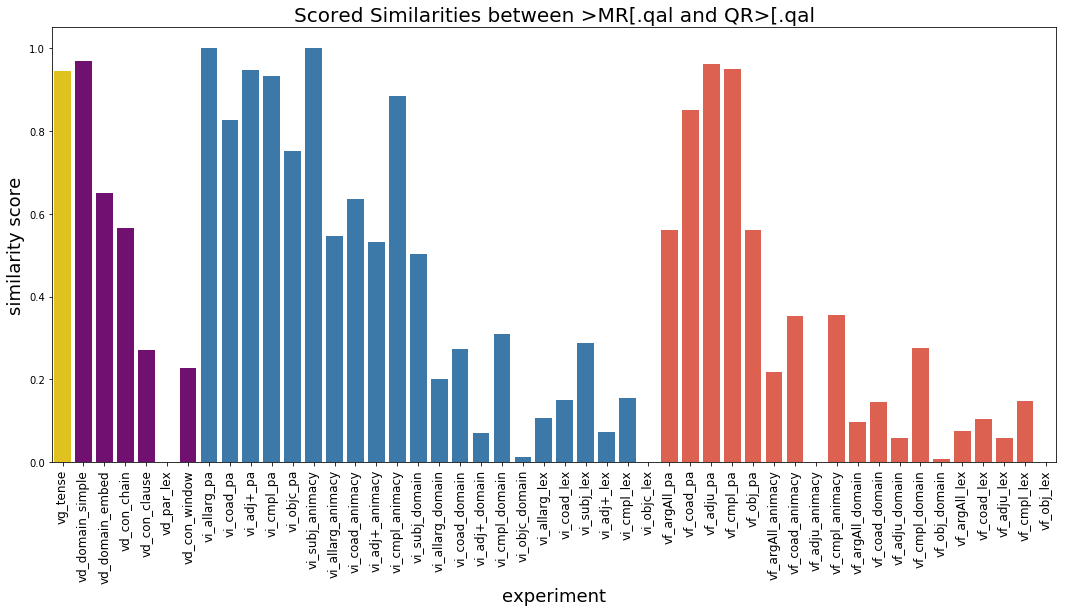

In [188]:
say_call = get_sim_experiments('>MR[.qal', 'QR>[.qal')

##### Observations
* high agreement across vi_allarg_pa, vi_adj+\_pa, and vi_cmpl_pa.
* high agreement in vf_coad_pa, vf_adju_pa, and vf_cmpl_pa
* high agreement in vi_cmpl_animacy
* high agreement in vi_subj_animacy
* Relatively large agreement in vf_coad_animacy and vf_cmpl_animacy'
* Comparatively lower agreement in object vi and vf experiments.

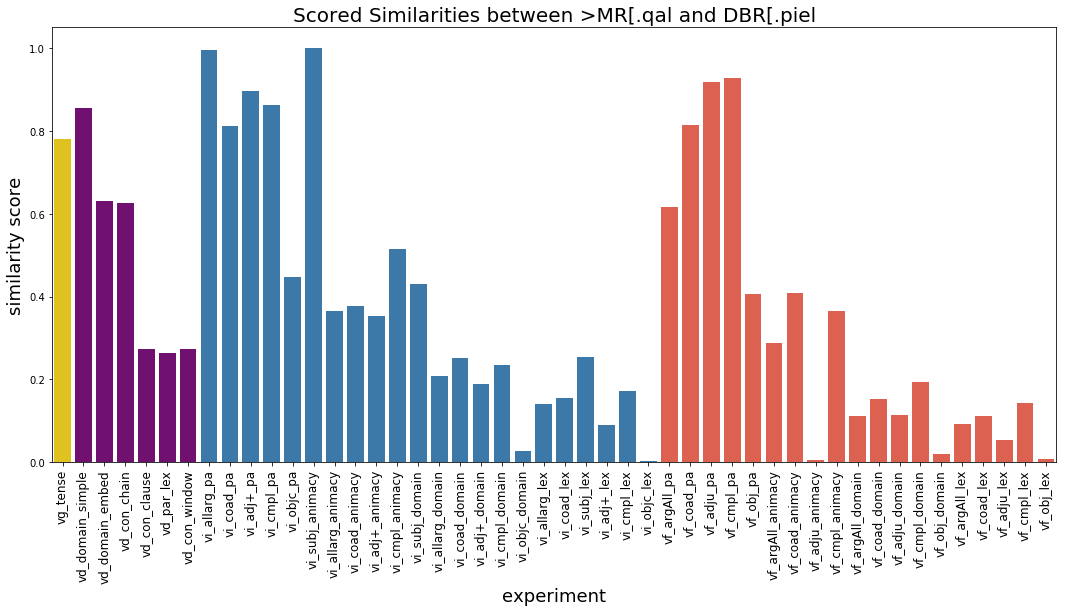

In [189]:
say_speak = get_sim_experiments('>MR[.qal', 'DBR[.piel')

##### Observations
* run of 5 across vi_pa experiments.
* high vi_subj_animacy
* Quite distinguished similarities in vf_cmpl_pa and vf_obj_pa
* Run of 3 across vf_argAll_pa, vf_coad_pa, and vf_adju_pa
* high vi_cmpl_animacy
* high parallelism agreement in comparison to קרא

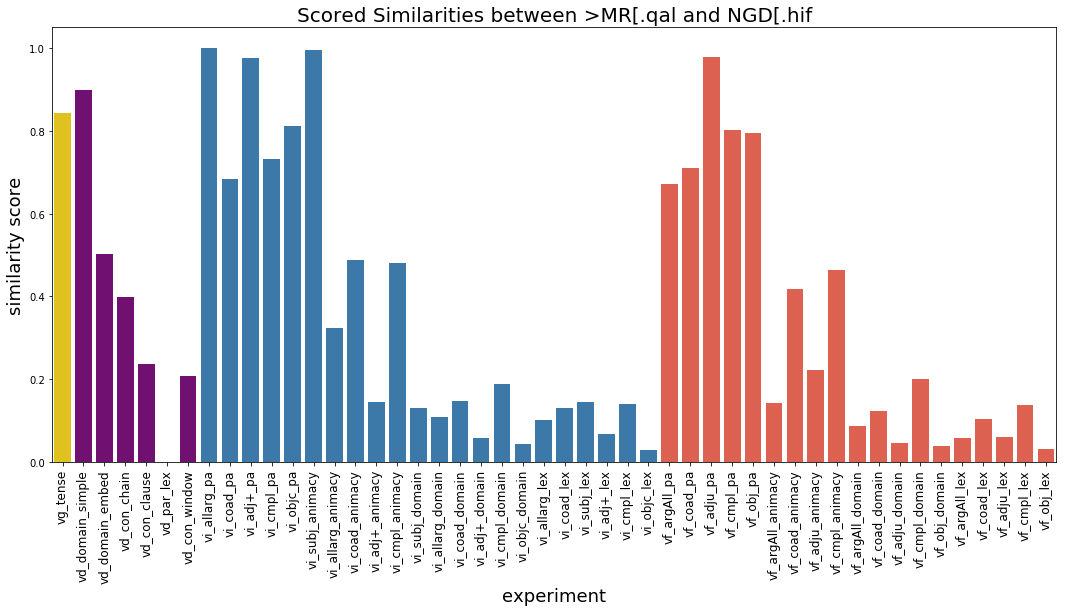

In [237]:
say_command = get_sim_experiments('>MR[.qal', 'NGD[.hif')

##### Observations

**TO DO**

#### Similarity Patterns for Unintuitive Matches

**>MR || <FH**

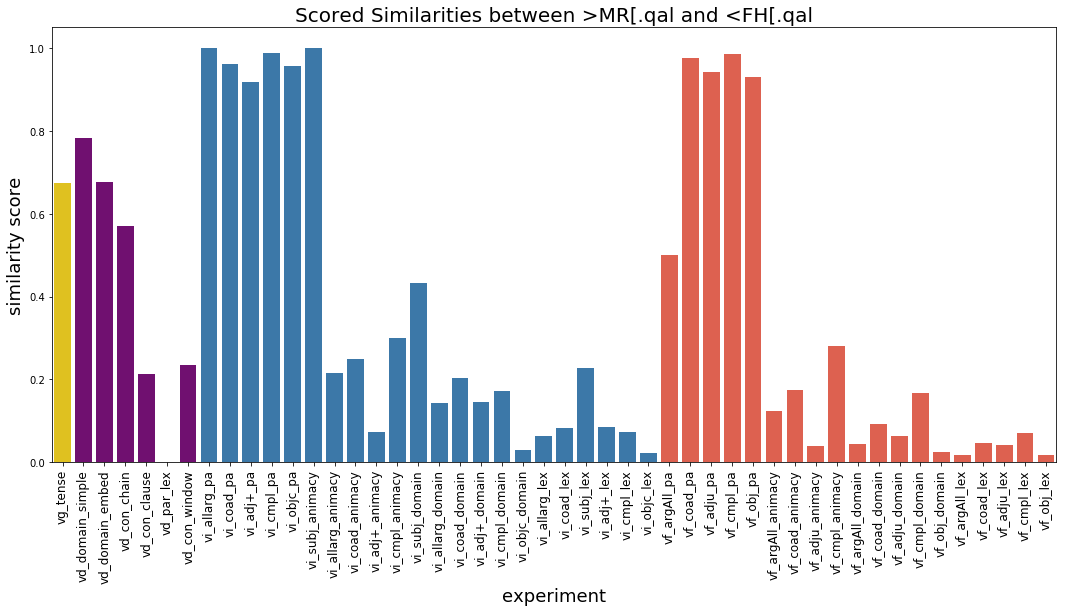

In [146]:
say_do = get_sim_experiments('>MR[.qal', '<FH[.qal')

##### Observations
* Run of 5 across the vi_pa experiments
* High vi_subj_animacy and vi_subj_domain
* High vf_cmpl_pa with corresponding high scores across vf_adju_pa, vf_obj_pa, and vf_coad_pa; though the last is noticeably lower. 

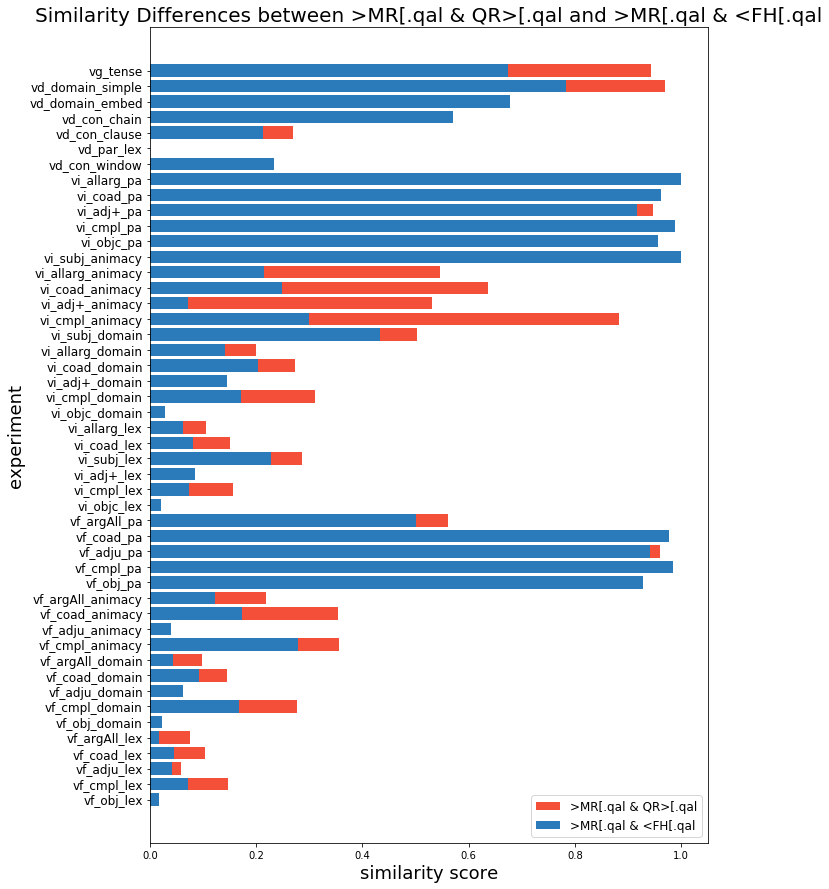

In [147]:
compareSets(('>MR[.qal', 'QR>[.qal'), ('>MR[.qal', '<FH[.qal'))

This chart allows us to compare directly the differences in similarity score between the two pairs. However, note that some changes, while not as big as others, are proportionately bigger than their original values. For instance, there is only an increase of ~0.2 in vf_coad_animacy. But overall this represents a 100% increase in relation to the total similarity score for vf_coad_animacy. We can better represent the significance of the differences by taking the ratio or percent of difference in relation to the similarity score, as `compareChange` below demonstrates.

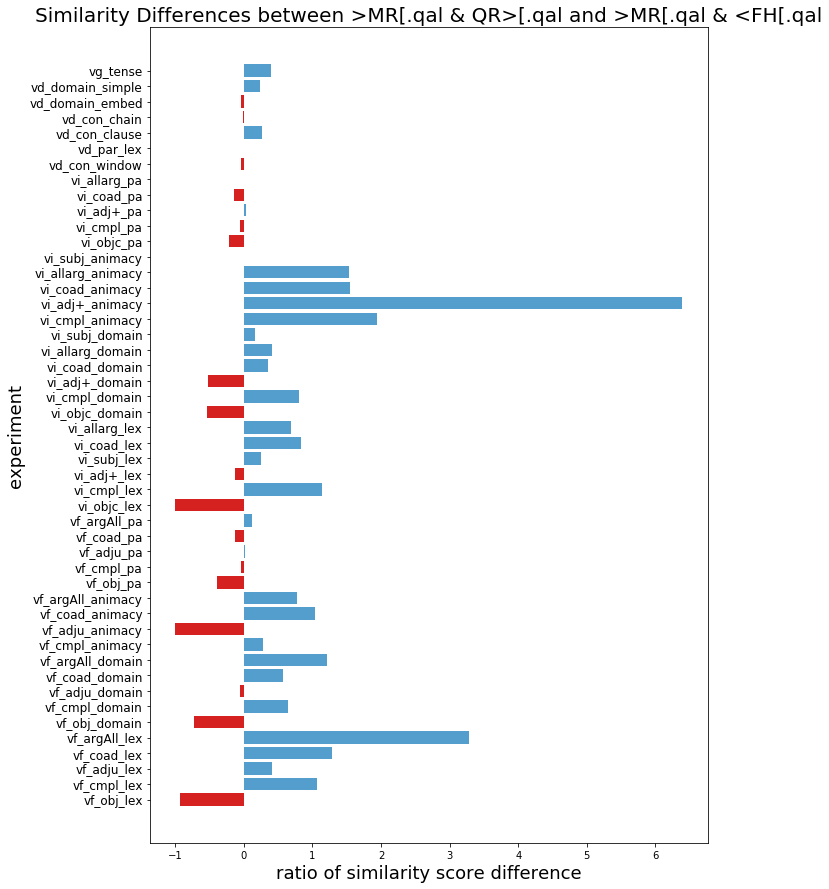

In [198]:
compareChange(('>MR[.qal', 'QR>[.qal'), ('>MR[.qal', '<FH[.qal'))

This chart shows the increases and decreases in similarity between the two pairs relative to the overall similarity score per experiment. To put it more simply, it shows the differences in similarity between >MR & QR> as compared with >MR & <FH. There are notable increases in similarity across the chart as a whole. But the most significant increases come in vi_adj+\_animacy (sixfold increase), and vf_argAll_lex. Othere increases are found in the complement and adjunct animacy experiments. 

There are notable decreases in similarity between several object experiments (vf_obj_domain, vf_obj_lex, vi_objc_domain, vi_objc_pa) as well as a sizeable decrease (-100%) in vf_adju_animacy.

What might be behind the high increase in similarity in the vf_allArg_lex experiment? We will gather the top common values between >MR and DBR. First, note how many dimensions this space consists of:

In [216]:
spaces['vf_argAll_lex'].pmi['>MR[.qal'].shape

(14761,)

The top similarities are found amongst the top 400 values between >MR and QR>.

In [221]:
# Top similarities between >MR and DBR

top_say = set(spaces['vf_argAll_lex'].pmi['>MR[.qal'].sort_values(ascending=False).head(400).index)
top_speak = set(spaces['vf_argAll_lex'].pmi['QR>[.qal'].sort_values(ascending=False).head(400).index)

top_say & top_speak

{'Adju.L_>MR[|Cmpl.>L_<M/',
 'Adju.L_>MR[|Cmpl.>L_>JC/',
 'Cmpl.>L_<BD/',
 'Cmpl.>L_<BDJHW/',
 'Cmpl.>L_>BCLWM/',
 'Cmpl.>L_CMW>L/',
 'Cmpl.>L_DWD==/',
 'Cmpl.>L_FR/',
 'Cmpl.>L_GJXZJ/',
 'Cmpl.>L_J<QB/',
 'Cmpl.>L_JFR>L/',
 'Cmpl.>L_JW>B/',
 'Cmpl.>L_LWV=/',
 'Cmpl.>L_MCH=/',
 'Cmpl.>L_MLK/',
 'Cmpl.>L_N<R/',
 'Cmpl.>L_YJB>/',
 'Cmpl.L_>BJTR/',
 'Cmpl.L_>BRM/',
 'Cmpl.L_>JC/',
 'Cmpl.L_CLMH=/',
 'Cmpl.L_CMCWN/',
 'Cmpl.L_HTK/',
 'Cmpl.L_J<QB/',
 'Cmpl.L_N<R/',
 'Cmpl.L_YDWQ/'}

Note such valuable parallels as `Adju.L_>MR[|Cmpl.>L_<M/`, and instance shared by both >MR and QR> where L + >MR is used and directed towards the "people" (>L <M). The algorithm has thus found a key similarity between these two terms.

vi_adj+\_animacy showed the highest increase in similarity. Here are the arguments in common between >MR and QR> for that experiment:

In [236]:
top_say = set(spaces['vi_adj+_animacy'].pmi['>MR[.qal'].sort_values(ascending=False).head(10).index) # top 10
top_speak = set(spaces['vi_adj+_animacy'].pmi['QR>[.qal'].sort_values(ascending=False).head(10).index) # top 10

top_say & top_speak

{'<L_inanimate', '>L_animate'}

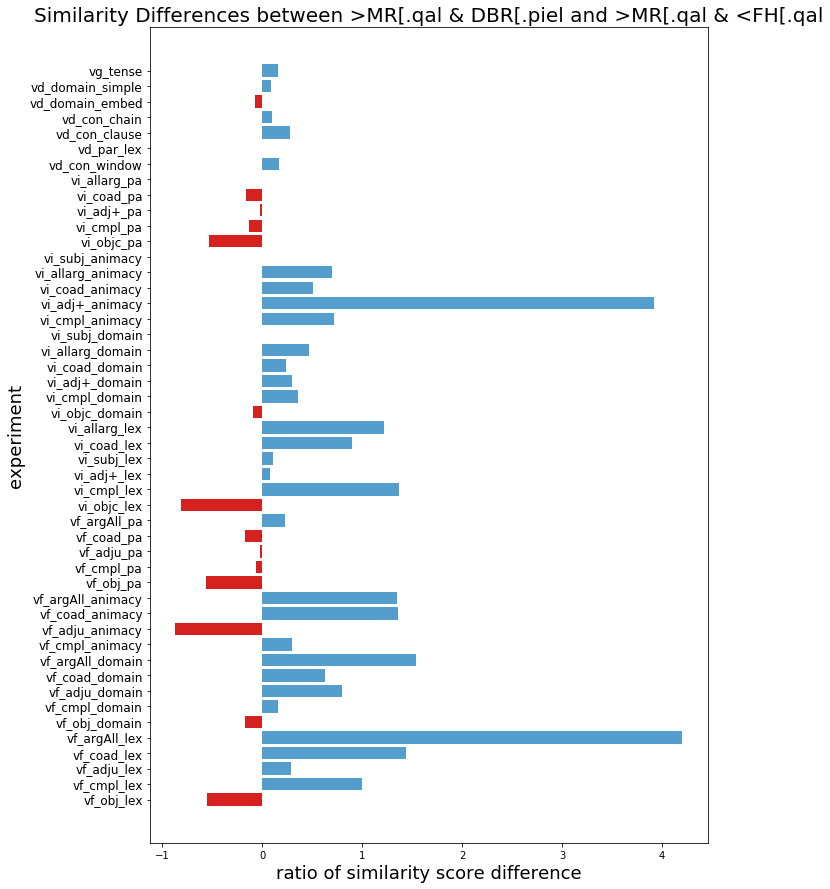

In [199]:
compareChange(('>MR[.qal', 'DBR[.piel'), ('>MR[.qal', '<FH[.qal'))

#### Observations

**TO DO**

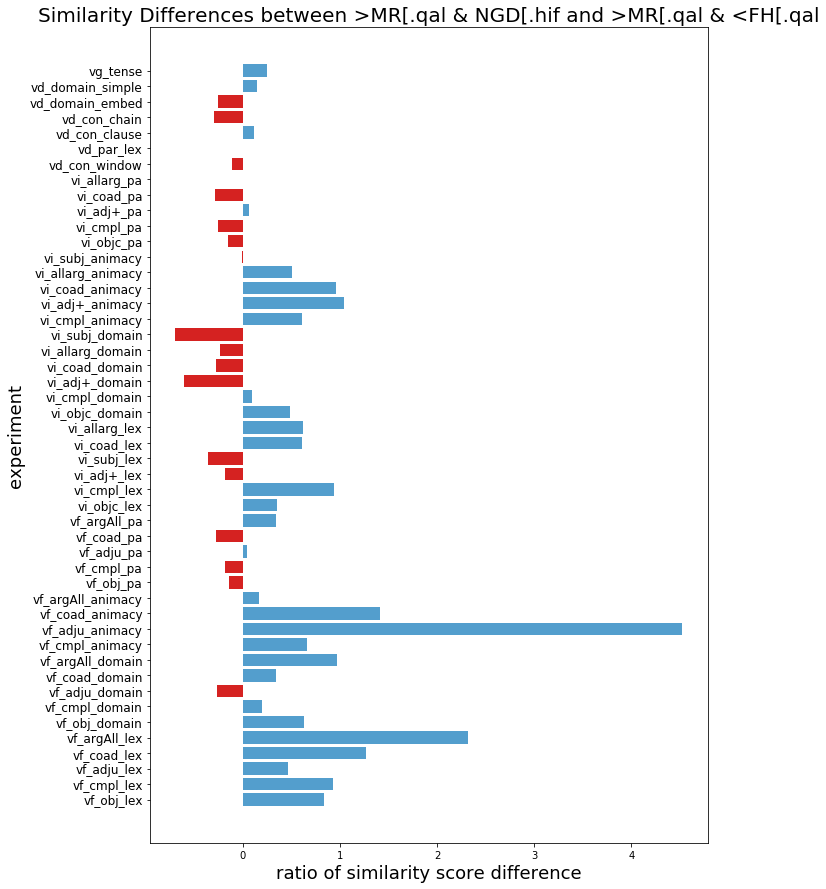

In [201]:
compareChange(('>MR[.qal', 'NGD[.hif'), ('>MR[.qal', '<FH[.qal'))

##### Observations
* Big increases in vi_adj+\_animacy and vf_adju_animacy.

** >MR || CLX**

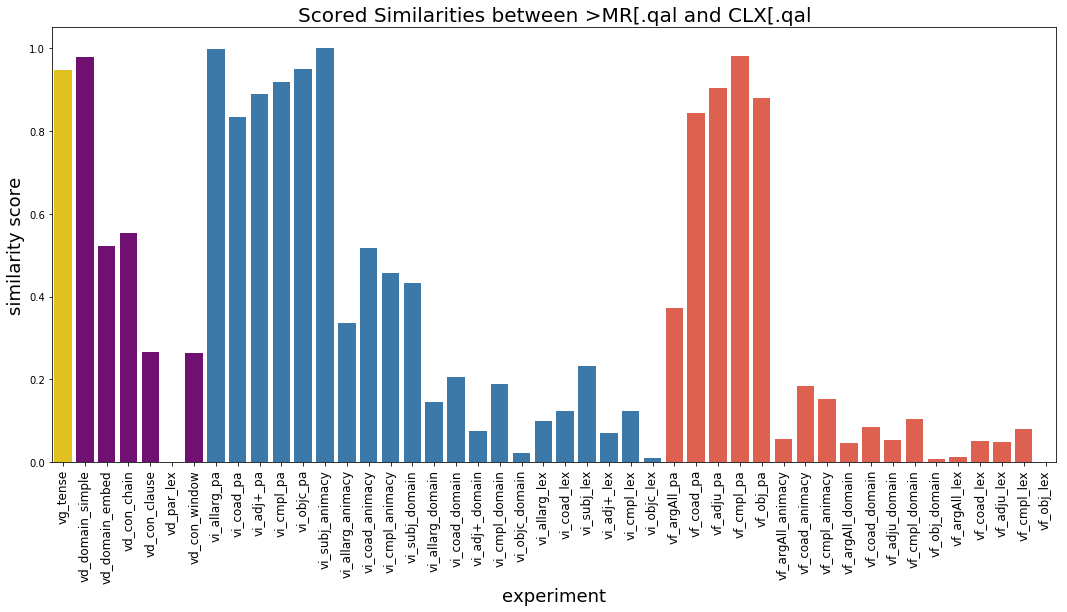

In [148]:
say_give = get_sim_experiments('>MR[.qal', 'CLX[.qal')

##### Observations



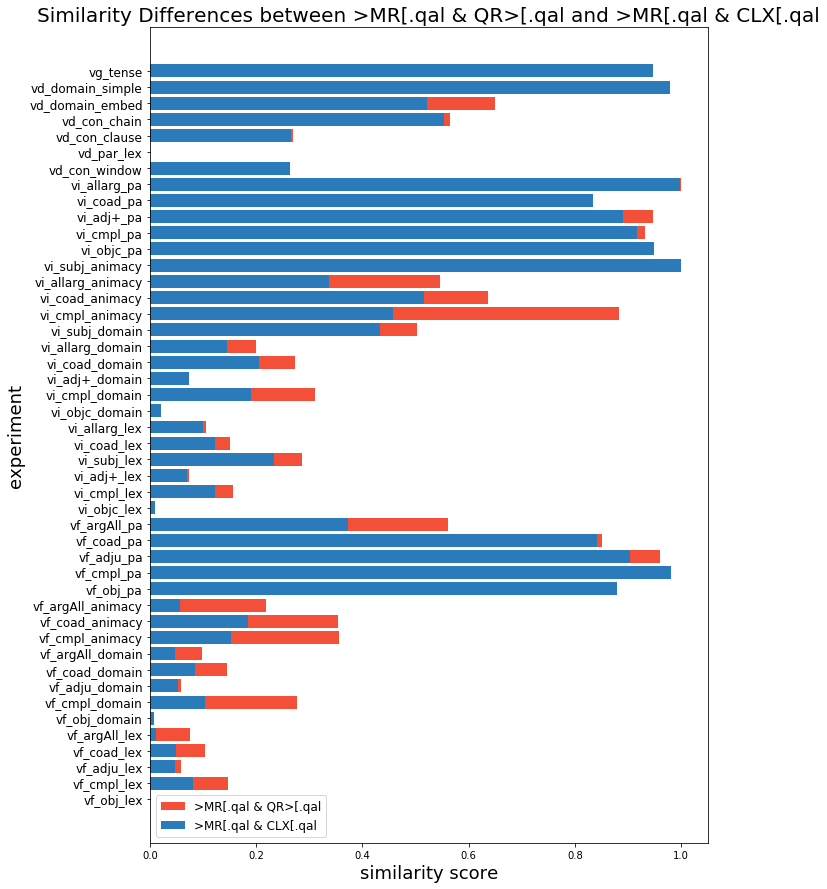

In [175]:
compareSets(('>MR[.qal', 'QR>[.qal'),('>MR[.qal', 'CLX[.qal'))

##### Observations

**TO DO**

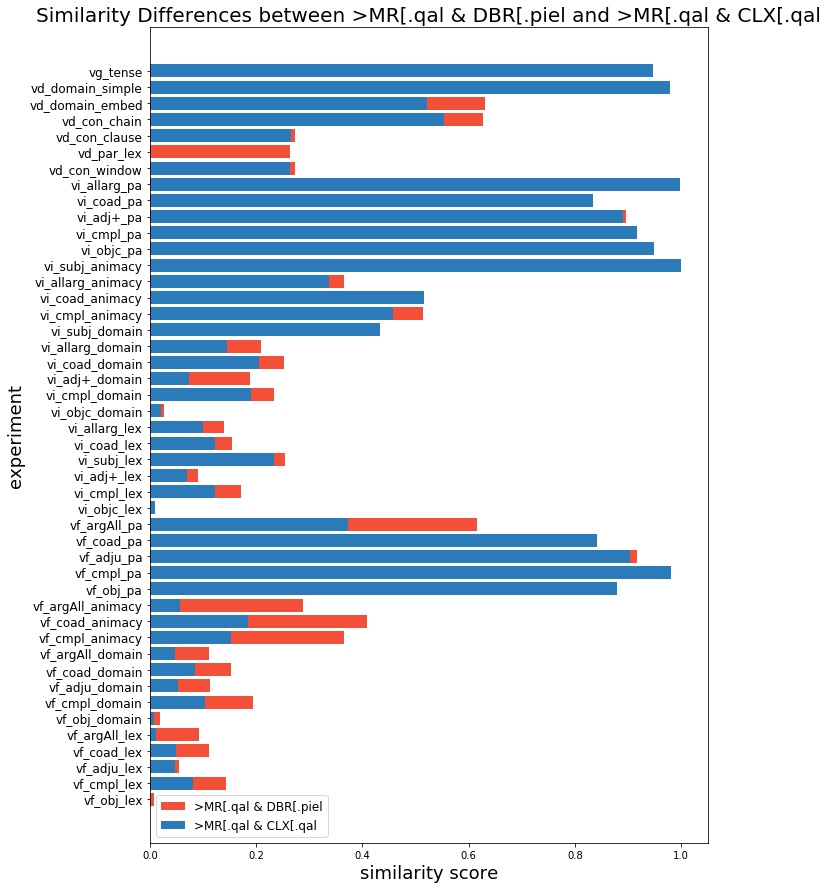

In [176]:
compareSets(('>MR[.qal', 'DBR[.piel'),('>MR[.qal', 'CLX[.qal'))

##### Observations

**TO DO**

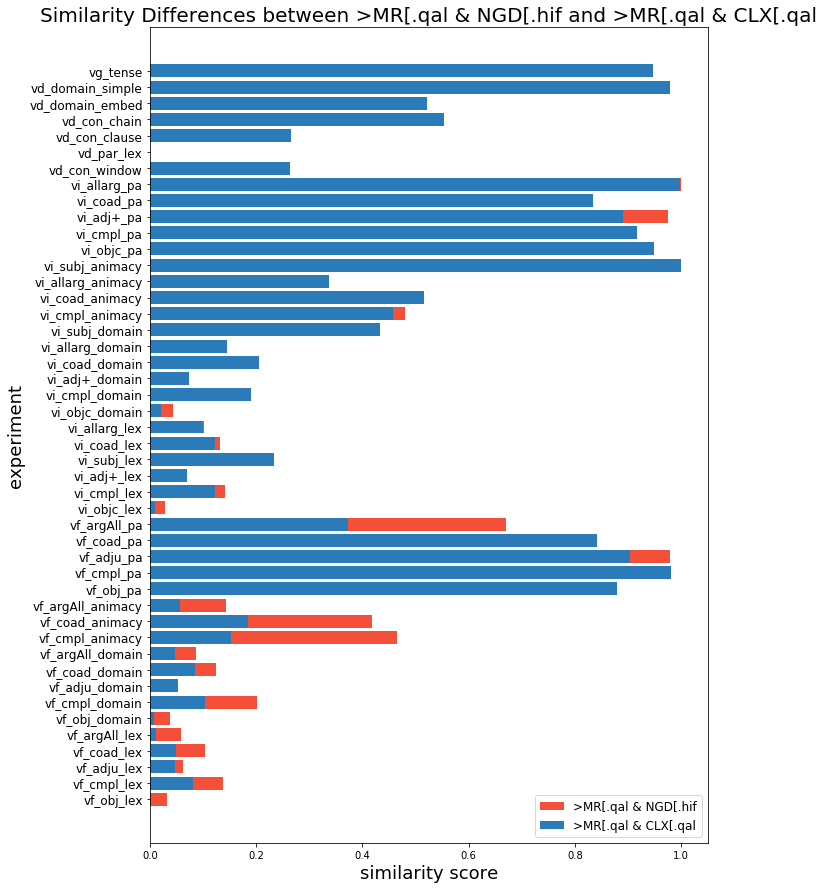

In [177]:
compareSets(('>MR[.qal', 'NGD[.hif'),('>MR[.qal', 'CLX[.qal'))

##### Observations

**TO DO**

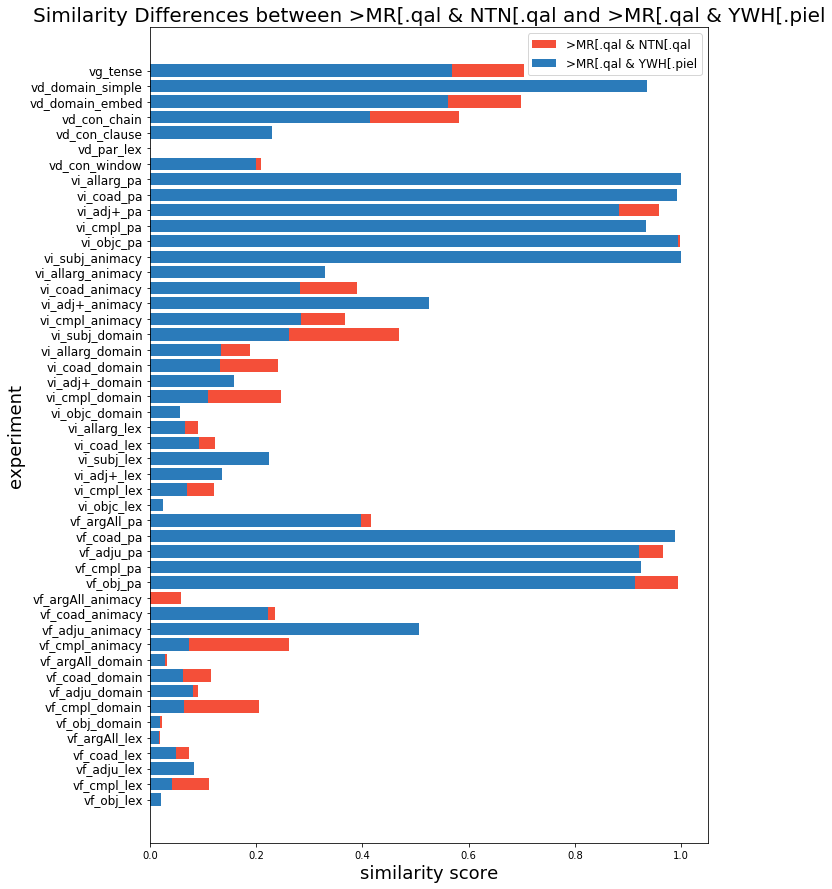

In [107]:
compareSets(('>MR[.qal', 'NTN[.qal'), ('>MR[.qal', 'YWH[.piel'))

The strongest increases occur in vf_cmpl_animacy and vf_cmpl_domain, accompanied with a slight increase also in vi_cmpl_animacy. There is also an increase in vi_subj_domain and vf_adju_pa.

Also note the similarity across semantic domain and lex experiments, which is lacking in the >MR || YWH pairing.

##### Conclusion

The primary common difference between >MR || NTN and >MR with intuitive matches is a marked decrease in similarity in the vf_adj+\_animacy experiment. The vf_cmpl_pa also consistently produces higher similarity scores across intuitive matches.

Now we continue with the next surprising match, the verb עשׂה.

#### Conclusions About the Matches of >MR with NTN and >FH

The similarity patterns between >MR and its surprising counterparts of NTN and >FH are close in many respects. They both share a high degree of similarity across the 5 vi_pa experiments as well as several of the verb frame experiments. This shows that these verb forms prefer similar argument patterns.

They also both share high similarity in the vi_subj_animacy experiment, which should not be surprising since these verbs are performed mostly by living actors.

But there is also a common difference between NTN and >FH and the more intuitively related terms of QR>, DBR, and YWH: the degree of similarity shared by the vi_adj+\_animacy experiment. This is occasionally accompanied by increases in similarity in the vi_cmpl_animacy and vf_cmpl_pa experiments.

I will need to pull out the similar patterns to see exactly where the similarities between >MR and its surprising matches lie. But what significance can be drawn from the primary difference, i.e. a higher similarity score in vi_adj+\_animacy and vi_cmpl_animacy?

Here are the tests' pmi adjusted counts for >MR for animacy:

In [159]:
spaces['vi_adj+_animacy'].pmi['>MR[.qal'].sort_values(ascending=False).head(3)

>L_animate     4.584963
B_inanimate    1.015920
B_animate      0.921997
Name: >MR[.qal, dtype: float64

N.B. that this ranking differs quite a bit from the raw counts, but has been fairly adjusted based on expected versus observed frequencies:

In [153]:
experiments['vi_adj+_animacy'].data['>MR[.qal'].sort_values(ascending=False).head(7)

B_inanimate     27.0
inanimate        5.0
B_animate        2.0
>L_animate       2.0
L_animate        1.0
<D_inanimate     1.0
<L_inanimate     1.0
Name: >MR[.qal, dtype: float64

Now the rankings for QR>, DBR, and YWH:

In [154]:
spaces['vi_adj+_animacy'].pmi['QR>[.qal'].sort_values(ascending=False).head(8)

>L_animate      3.584963
NGD/_animate    3.584963
<D_inanimate    2.288188
MN_inanimate    2.215729
<L_inanimate    2.099536
<M_animate      1.362570
inanimate       0.652649
K_inanimate     0.646363
Name: QR>[.qal, dtype: float64

In [155]:
spaces['vi_adj+_animacy'].pmi['DBR[.piel'].sort_values(ascending=False).head(8)

MWL/_inanimate    6.754888
>L_animate        3.584963
LM<N_animate      3.584963
NGD/_animate      3.584963
<L_animate        3.385654
BJN/_inanimate    3.231326
MN_inanimate      2.023084
B_inanimate       1.720464
Name: DBR[.piel, dtype: float64

In [156]:
spaces['vi_adj+_animacy'].pmi['YWH[.piel'].sort_values(ascending=False).head(8)

>L_inanimate      3.667425
>L_animate        3.584963
<L_animate        3.385654
inanimate         2.085609
MN_inanimate      0.800691
L_inanimate       0.054448
>YL/_animate      0.000000
BLT/_inanimate    0.000000
Name: YWH[.piel, dtype: float64

Note that the highest common occurrence is the `>L_animate` argument, which is the most common argument in all but YWH, where it is still second.

Now the surprising matches:

In [168]:
spaces['vi_adj+_animacy'].pmi['NTN[.qal'].sort_values(ascending=False).head(18)

LM<N_inanimate    5.169925
LM<N_animate      4.584963
BJN/_inanimate    3.816288
<D_animate        3.584963
L_animate         3.471954
<L_animate        3.385654
B_animate         3.381429
TXT/_inanimate    3.252387
<M_inanimate      3.054448
MN_inanimate      3.023084
MN_animate        2.646363
L_inanimate       2.376376
<D_inanimate      2.118263
B_inanimate       2.068387
K_inanimate       1.968291
inanimate         1.578649
K_animate         1.488101
>L_inanimate      0.000000
Name: NTN[.qal, dtype: float64

In [173]:
spaces['vi_adj+_animacy'].pmi['<FH[.qal'].sort_values(ascending=False).head(24)

MSH=/_inanimate    6.754888
BJN/_inanimate     5.231326
NGD/_animate       5.169925
<D_animate         4.584963
LM<N_animate       4.584963
B<D/_animate       4.432959
NGD/_inanimate     4.432959
L_inanimate        4.008644
<M_animate         3.947533
animate            3.896907
<L_inanimate       3.362570
L_animate          3.265503
B_inanimate        3.226816
B_animate          3.091922
<M_inanimate       3.054448
K_inanimate        2.816288
K_animate          2.810029
inanimate          2.688273
MN_animate         2.231326
<L_animate         1.800691
<D_inanimate       1.703225
TXT/_inanimate     1.667425
MN_inanimate       1.537657
MWL/_inanimate     0.000000
Name: <FH[.qal, dtype: float64

`>L_animate`, by contrast, occurs far lower in these counts. And these two verbs exhibit a greater diversity of argument types. 

We can make a more generalized statement based on this distinction that the communication verbs share the unique feature of directing their action **towards** an **animate adjunct**.

### היה.qal

In [189]:
sim['HJH[.qal'].sort_values(ascending=False).head(6)

HJH[.qal    1.000000
NTN[.qal    0.393290
<FH[.qal    0.377872
BW>[.qal    0.375166
JCB[.qal    0.352647
JY>[.qal    0.346812
Name: HJH[.qal, dtype: float64

All of the similar terms are surprising for this verb. There is thus the added difficulty here that there is no apparent intuitively similar term to test the surprising occurrences against. Across the first two verbs, though, some indicators are visible. In its comparisons with NTN and <FH the verb HJH rates low for experiments that test for objects.

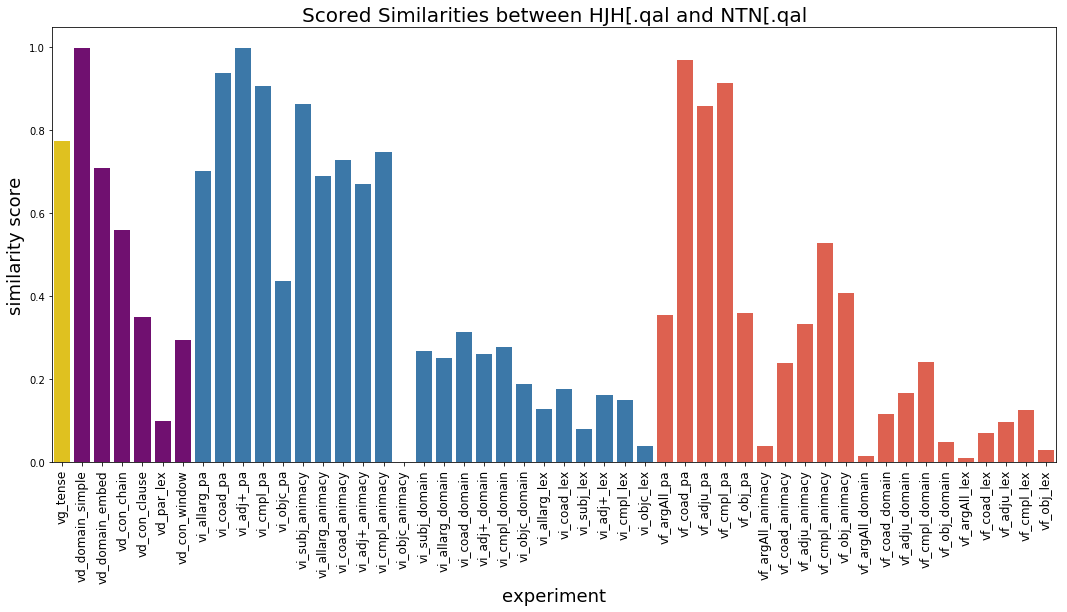

In [181]:
be_give = get_sim_experiments('HJH[.qal', 'NTN[.qal')

##### Observations

* High agreement across three vi_pa experiments: vi_coad_pa, vi_adj+\_pa, and vi_cmpl_pa; the same is true for the same corresponding frame experiments.
* High agreement across the five vi_animacy experiments
* high agreement with the vf_cmpl_animacy experiment
* Lower agreement in vf_adju_animacy and vf_obj_animacy in comparison to the inventory experiments 
* Much lower vi_objc_pa and vf_objc_pa scores in comparison to their sister experiments.These lower figures for the object also brings down the vi/vf_allArg_pa experiments.

What is perhaps the cause behind the high agreement between the vi_adj+\_pa and the vf_cmpl_animacy experiments?

In [195]:
spaces['vi_adj+_pa'].pmi['HJH[.qal'].sort_values(ascending=False)

adj+    6.075901
ø       5.062947
Name: HJH[.qal, dtype: float64

In [196]:
spaces['vi_adj+_pa'].pmi['NTN[.qal'].sort_values(ascending=False)

adj+    4.610286
ø       4.459580
Name: NTN[.qal, dtype: float64

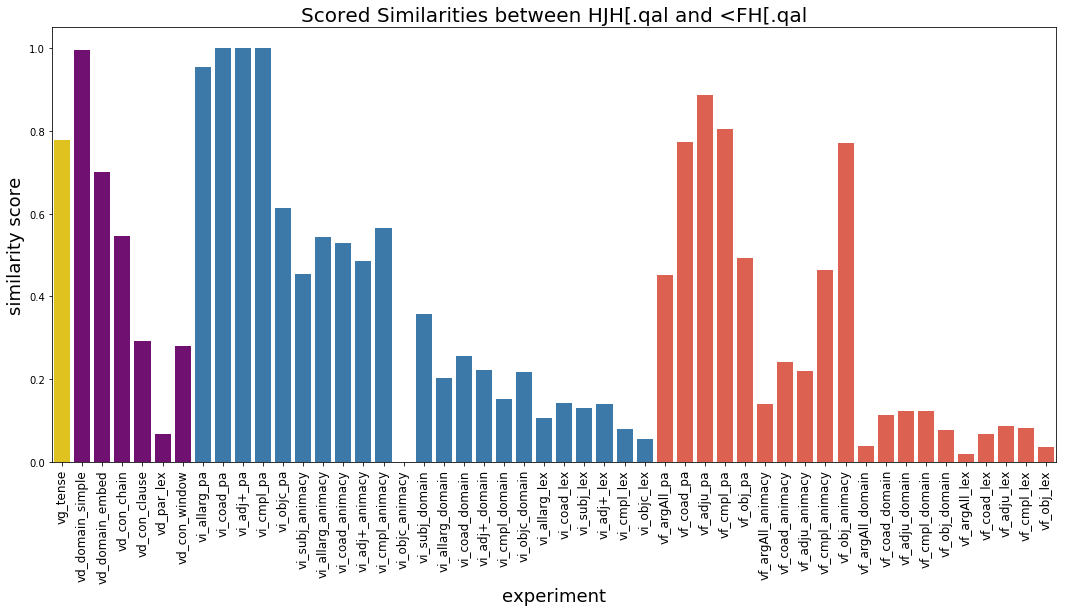

In [183]:
be_do = get_sim_experiments('HJH[.qal', '<FH[.qal')

The same marked decrease in similarity for the object experiments can be seen in the comparison with <FH above. There is likewise a marked decrease in the similarity registered by the vi_subj_animacy experiment.

The final three verbs have a lot of agreement when it comes to their preference for objects (or probably lack of in this case). However, there is a slight decrease in similarity in the vf_cmpl_pa experiment relative to the other presence/absence frame experiments.

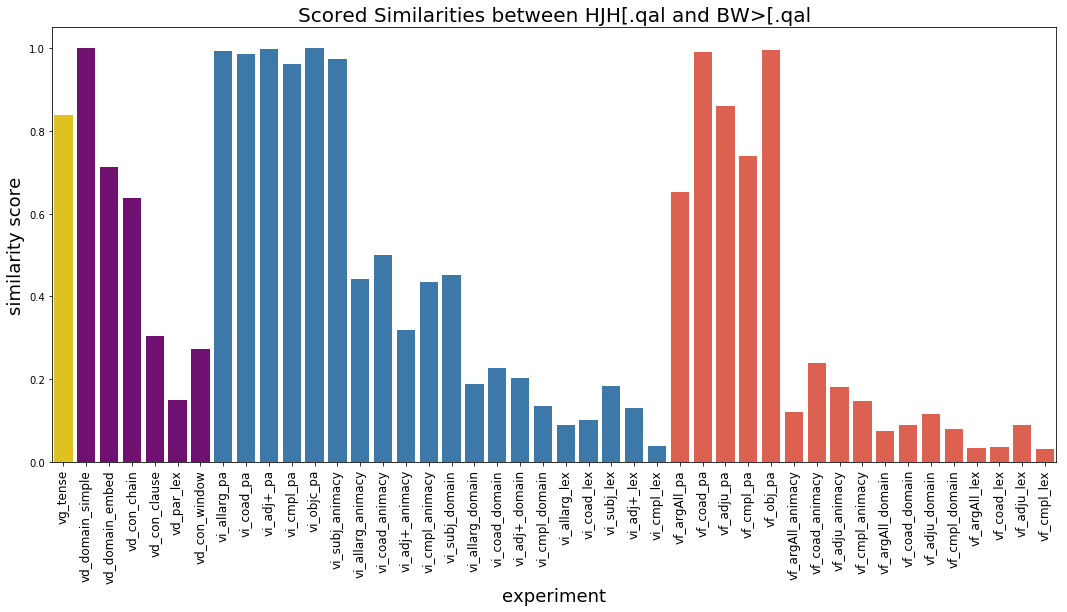

In [185]:
be_come = get_sim_experiments('HJH[.qal', 'BW>[.qal')

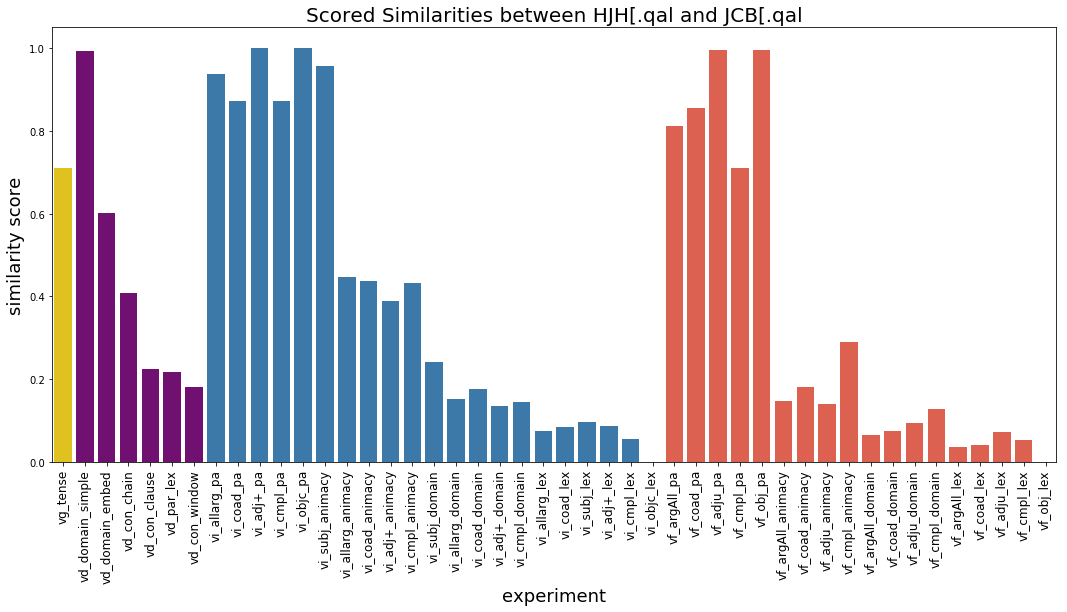

In [186]:
be_sit = get_sim_experiments('HJH[.qal', 'JCB[.qal')

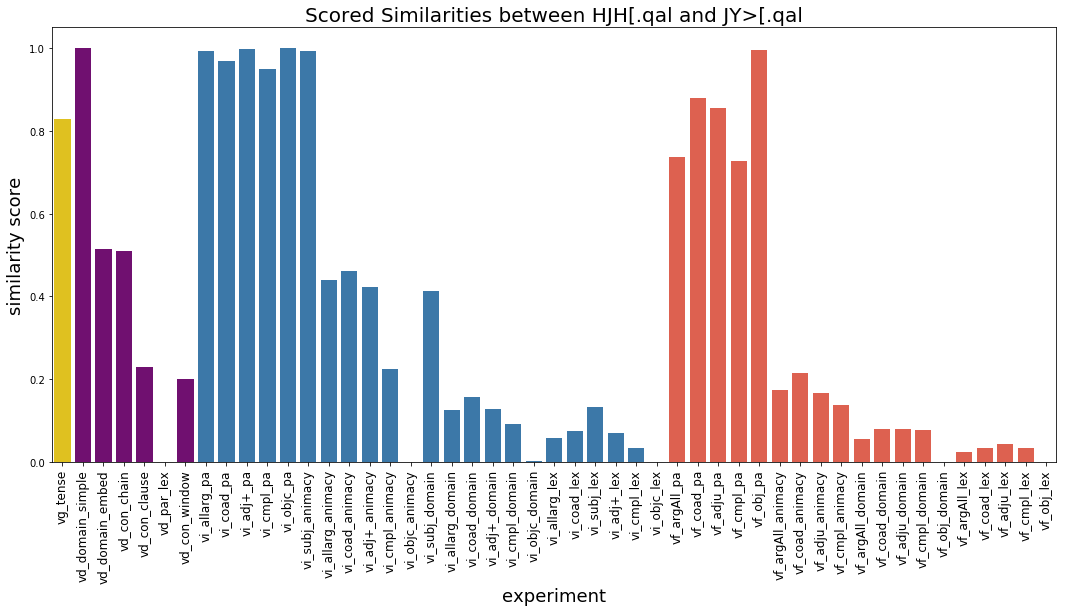

In [187]:
be_goout = get_sim_experiments('HJH[.qal', 'JY>[.qal')

### נתן.qal

In [489]:
print('Similarity scores for NTN:')
sim['NTN[.qal'].sort_values(ascending=False).head(10)

Similarity scores for NTN:


NTN[.qal    1.000000
<FH[.qal    0.442549
FJM[.qal    0.421266
BW>[.hif    0.416374
LQX[.qal    0.414786
HJH[.qal    0.393290
NF>[.qal    0.372069
QR>[.qal    0.371095
CLX[.qal    0.353100
>MR[.qal    0.348045
Name: NTN[.qal, dtype: float64

What is interesting about this is that HJH is intuitively not similar to NTN; FJM is similar in meaning; and LQX is an antonym. They are "cousins" in some sense; but surely one of these cousins was adopted into the family! What areas of similarity and differences distinguish these three lexemes?

First we look at the nature of the similarities between the three lexemes and NTN.

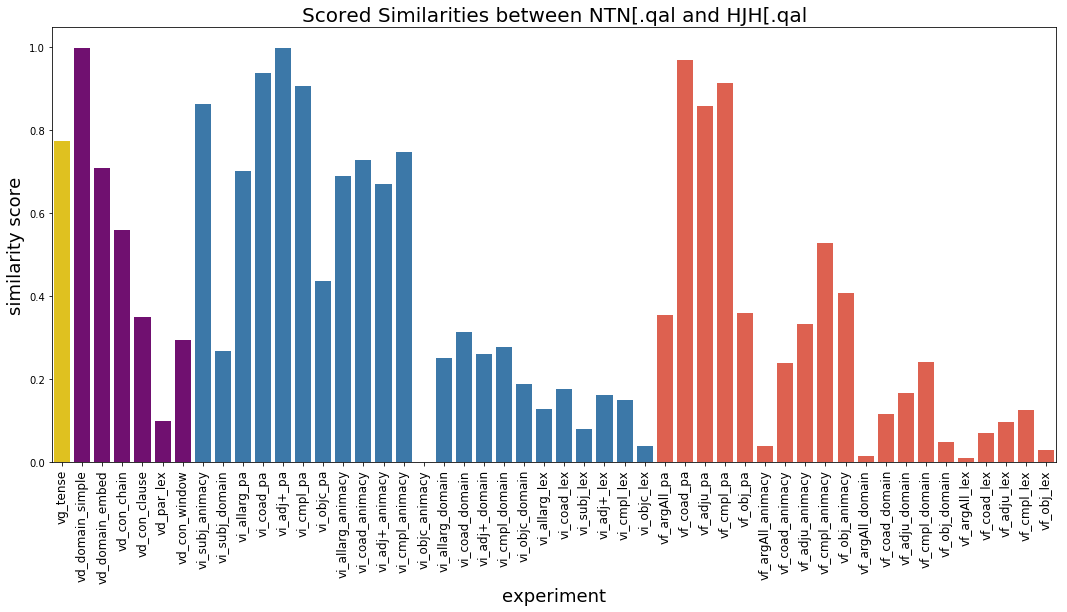

In [78]:
give_be = get_sim_experiments('NTN[.qal', 'HJH[.qal')

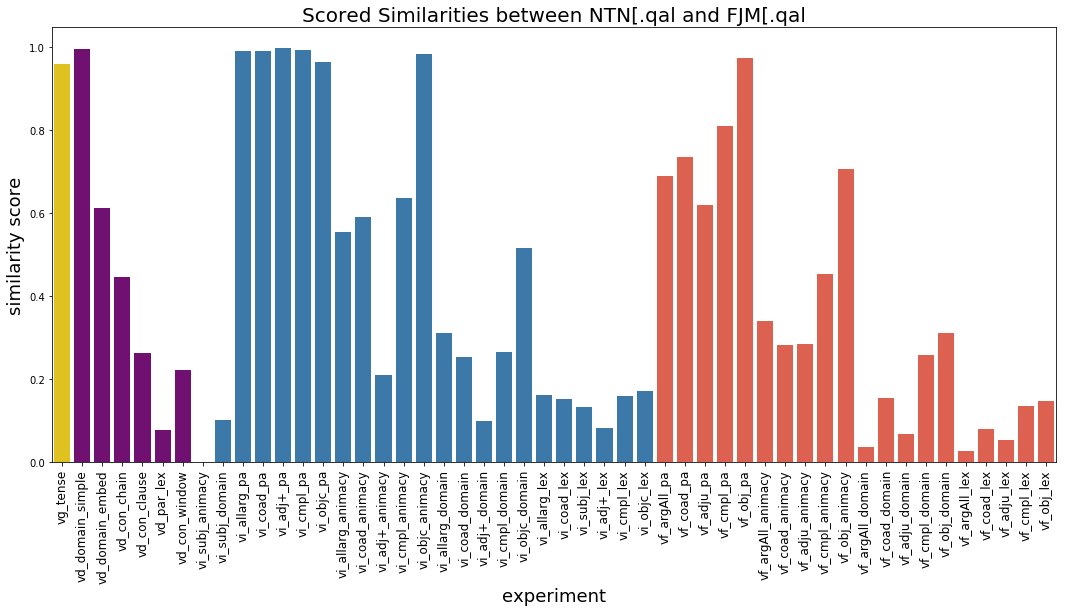

In [480]:
give_set = get_sim_experiments('NTN[.qal', 'FJM[.qal')

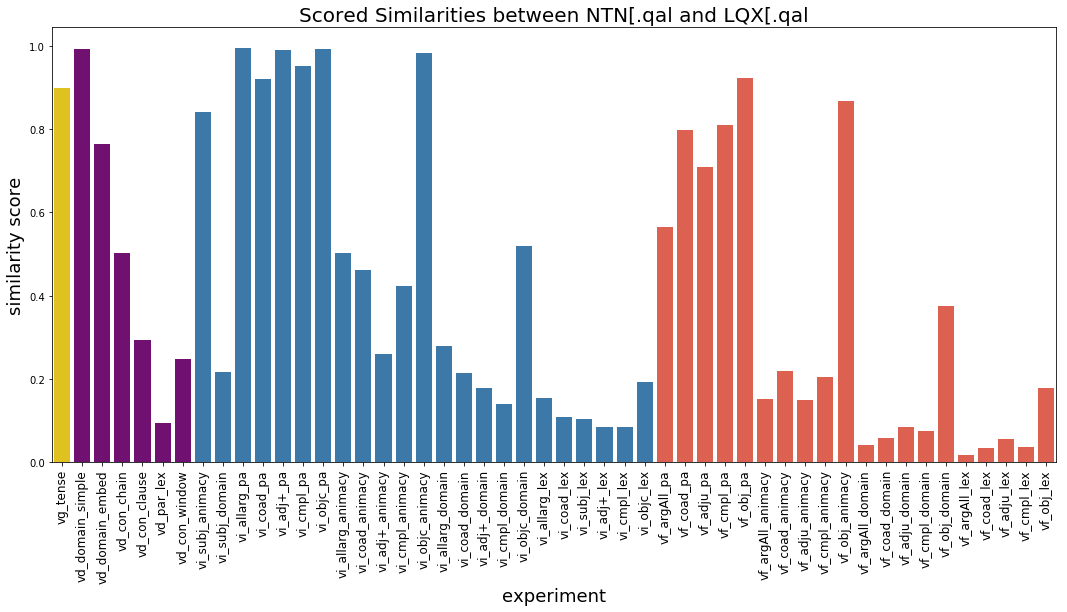

In [481]:
get_sim_experiments('NTN[.qal', 'LQX[.qal', returnData=False)

**Now we highlight the particular differences in similarity between sets of pairs. Or in other words, we examine the difference in similarity patterns between two pairs of words.**

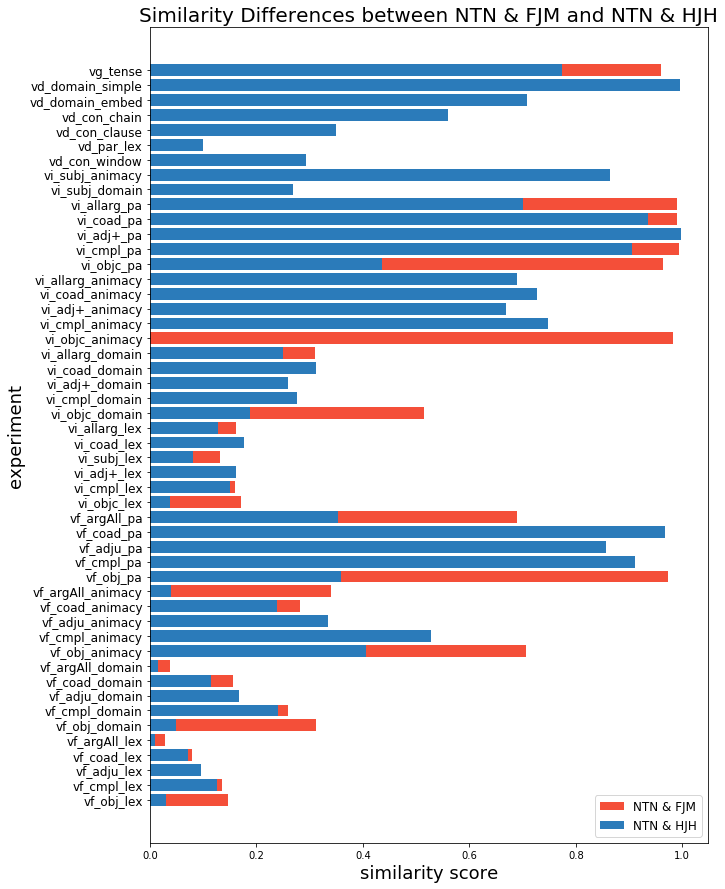

In [483]:
compare_simPatterns(give_set, give_be, pairs=['NTN & FJM', 'NTN & HJH'])

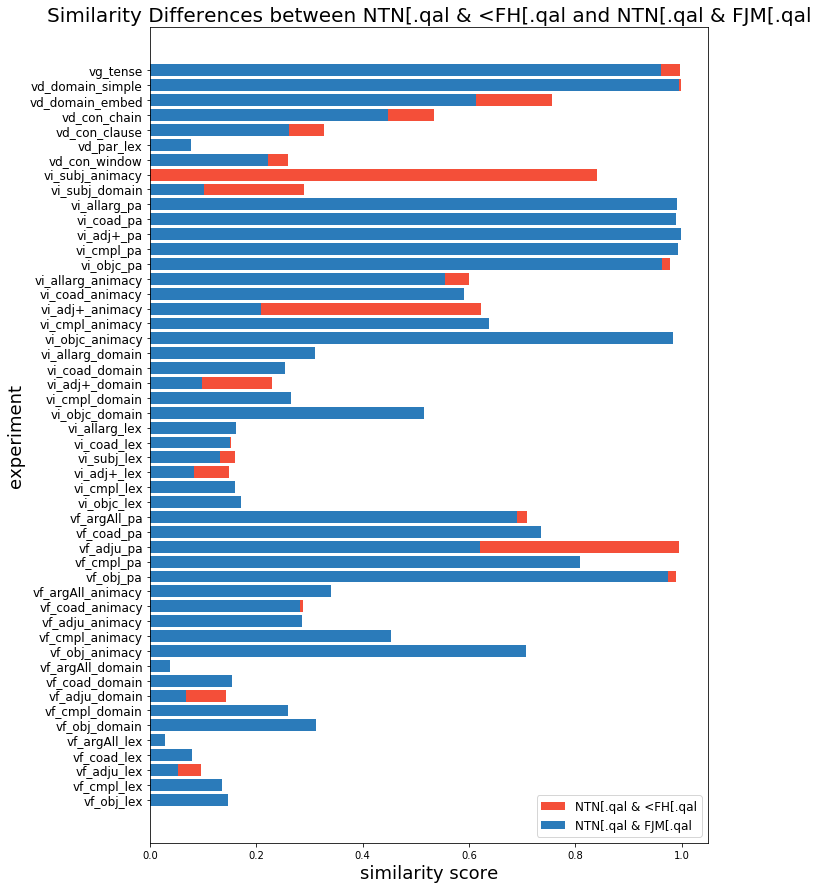

In [484]:
compareSets(('NTN[.qal', '<FH[.qal'), ('NTN[.qal', 'FJM[.qal'))

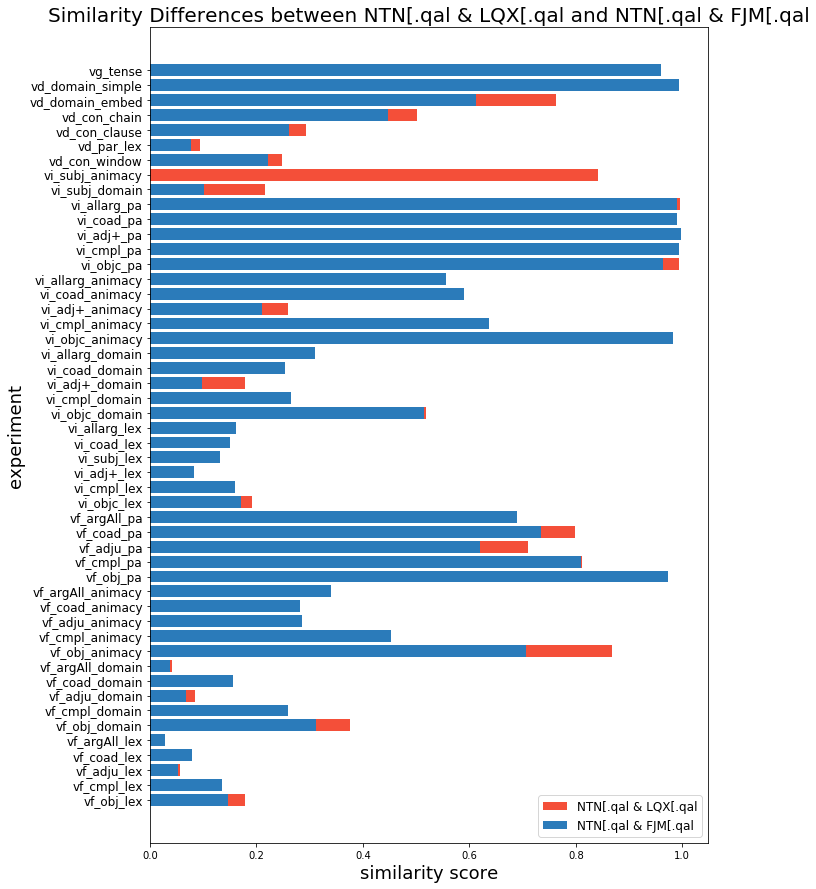

In [485]:
compareSets(('NTN[.qal', 'LQX[.qal'), ('NTN[.qal', 'FJM[.qal'))

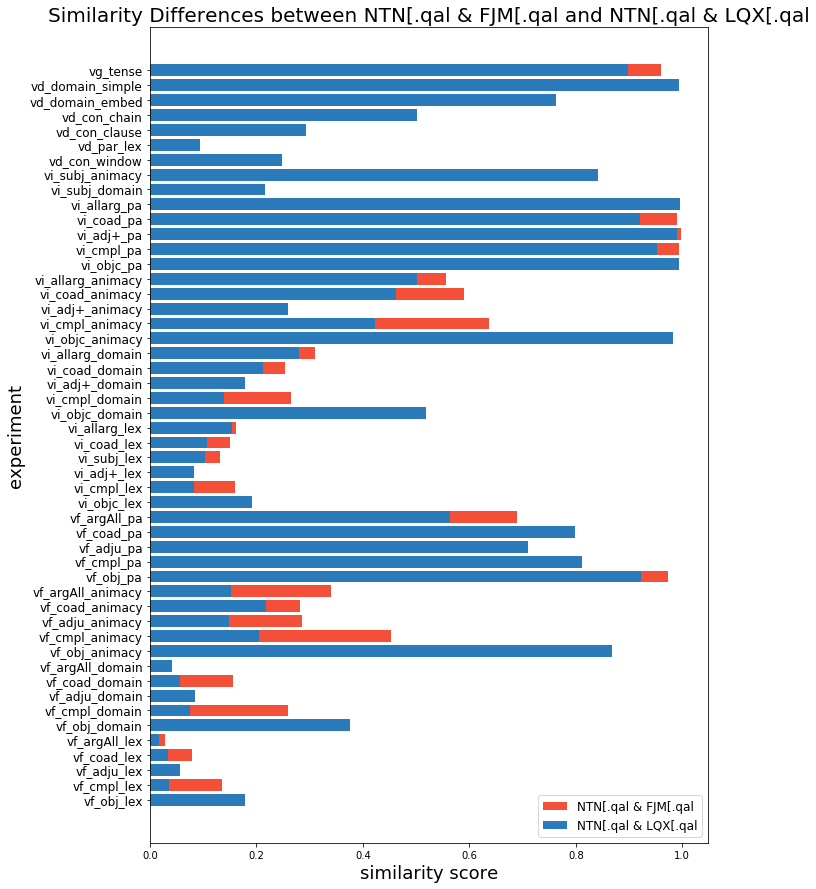

In [486]:
compareSets(('NTN[.qal', 'FJM[.qal'), ('NTN[.qal', 'LQX[.qal'))